In [42]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.corpus import stopwords

import mglearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<h3>Задание №2</h3>

Создайте свой «мешок слов», например, набор из 20-25 отзывов о чем-либо, напишите краткое пояснение к данным.

In [43]:
# Отзывы на английском языке
reviews_train_eng = load_files('reviews/train/')
reviews_test_eng = load_files('reviews/test/')

# Декодирование в формат utf-8 для корректной обработки
text_train_eng = [item.decode('utf-8') for item in reviews_train_eng.data]
y_train_eng = reviews_train_eng.target

text_test_eng = [item.decode('utf-8') for item in reviews_test_eng.data]
y_test_eng = reviews_test_eng.target

<h4>Создание мешка слов</h4>

Поскольку количество отзывов мало, я не стал ограничивать количество токенов параметром min_df

In [44]:
count_vectorizer_eng = CountVectorizer()
count_vectorizer_eng.fit(text_train_eng)

X_train_eng = count_vectorizer_eng.transform(text_train_eng)


<h4>Размерность мешка слов</h4>

In [45]:
print('{} - eng'.format(X_train_eng.shape))

(20, 174) - eng


<h4>Исследование признаков</h4>

In [46]:
feature_names_eng = count_vectorizer_eng.get_feature_names_out()

<h4>Первые 10 признаков</h4>

In [47]:
print(feature_names_eng[:10])

['action' 'adds' 'adrenaline' 'affecting' 'alienate' 'amidst' 'amplifying'
 'an' 'and' 'are']


<h4>Последние 10 признаков</h4>

In [48]:
print(feature_names_eng[-11:])

['throughout' 'tighter' 'times' 'to' 'tone' 'universe' 'viewers' 'visual'
 'while' 'wide' 'with']


<h3>Задание №3</h3>

Создайте словарь стоп-слов, примените стоп-слова к своему «мешку слов»

**Для применения стоп слов для русского языка необходимо установить библиотеку nltk**

In [49]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [50]:
stop_words_english = set(stopwords.words('english'))

count_vectorizer_eng = CountVectorizer(stop_words=list(stop_words_english)) ### Здесь
count_vectorizer_eng.fit(text_train_eng)

X_train_eng = count_vectorizer_eng.transform(text_train_eng)

print('Размерность мешка слов (eng): {}'.format(X_train_eng.shape))

Размерность мешка слов (eng): (20, 150)


Для английского языка количество признаков сократилось с 868 до 759 (109 признаков)

<h3>Задание №4</h3>

Масштабируйте данные с помощью tf-idf

In [51]:
pipe = make_pipeline(TfidfVectorizer(norm=None), LogisticRegression())

# Параметры для логистической регрессии
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'saga'],
    'logisticregression__max_iter': [10000, 20000, 30000],
    
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]
}

grid_search_eng = GridSearchCV(pipe, param_grid, cv=4)
grid_search_eng.fit(text_train_eng, y_train_eng)

GridSearchCV(cv=4,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(norm=None)),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1, 1.0, 10.0,
                                                   100.0],
                         'logisticregression__max_iter': [10000, 20000, 30000],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['liblinear', 'saga'],
                         'tfidfvectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]})

In [52]:
print('Лучший результат (eng): {}'.format(grid_search_eng.best_score_))
print('Лучшие параметры (eng): {}'.format(grid_search_eng.best_params_))

Лучший результат (eng): 0.65
Лучшие параметры (eng): {'logisticregression__C': 0.1, 'logisticregression__max_iter': 20000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga', 'tfidfvectorizer__ngram_range': (1, 3)}


<h3>Задание №5</h3>

Исследуйте коэффициенты модели

<h4>Наименее важные признаки</h4>

In [53]:
tfidf_vectorizer = grid_search_eng.best_estimator_.named_steps['tfidfvectorizer']
logistic_regression = grid_search_eng.best_estimator_.named_steps['logisticregression']

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
coefficients = logistic_regression.coef_.flatten()

features_df = pd.DataFrame({'Feature': feature_names, 'Value': coefficients})

print(features_df.sort_values(by='Value', ascending=False).tail(20))

                 Feature     Value
294      holmes universe -0.026782
584         the sherlock -0.026782
585  the sherlock holmes -0.026782
293               holmes -0.026782
592                their -0.032517
242                 feel -0.035227
384                might -0.036135
461           plot might -0.036135
460                 plot -0.036135
578             the plot -0.036135
579       the plot might -0.036135
514                 some -0.036298
351                 lack -0.036298
307               impact -0.036298
14       affecting their -0.037986
13             affecting -0.037986
417         occasionally -0.040169
148                could -0.040307
442              overall -0.051746
102              certain -0.063329


<h4>Наиболее важные признаки</h4>

In [54]:
tfidf_vectorizer = grid_search_eng.best_estimator_.named_steps['tfidfvectorizer']
logistic_regression = grid_search_eng.best_estimator_.named_steps['logisticregression']

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
coefficients = logistic_regression.coef_.flatten()

features_df = pd.DataFrame({'Feature': feature_names, 'Value': coefficients})

print(features_df.sort_values(by='Value', ascending=False).head(20))

                        Feature     Value
488                      sadasd  0.130824
31                          and  0.040654
212                   enriching  0.039048
213               enriching the  0.039048
227                  experience  0.035999
538                    suspense  0.035992
26                           an  0.035571
429                  of mystery  0.035471
313                          in  0.035471
409                     mystery  0.035471
574                 the musical  0.023927
527            storytelling and  0.023927
526                storytelling  0.023927
76    beautifully enriching the  0.023927
407               musical score  0.023927
38                and emotional  0.023927
75        beautifully enriching  0.023927
39          and emotional depth  0.023927
528  storytelling and emotional  0.023927
201                   emotional  0.023927


<h4>Теплокарта для усредненной правильности перекрестной проверки</h4>

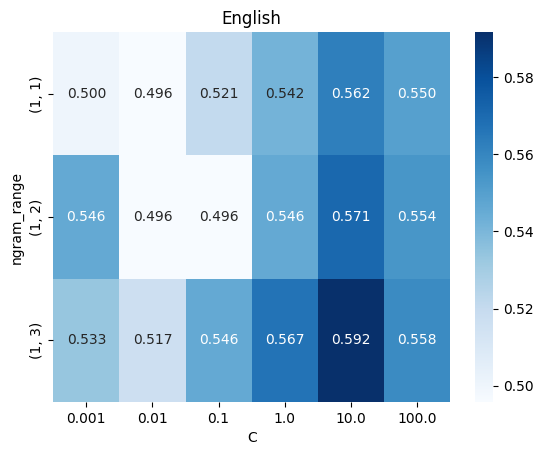

In [55]:
heatmap_data_eng = results_eng.pivot_table(index='param_tfidfvectorizer__ngram_range', columns='param_logisticregression__C', values='mean_test_score')
prediction_eng = grid_search_eng.predict(text_test_eng)
sns.heatmap(heatmap_data_eng, annot=True, fmt=".3f", cmap="Blues")
plt.title('English')
plt.xlabel('C')
plt.ylabel('ngram_range')
plt.show()


<h4>Отчет для модели на английском языке</h4>

In [56]:
print(classification_report(y_test_eng, prediction_eng, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



<h3>Задание №6</h3>

Сделайте выводы по работе.

Согласно отчету и матрице ошибок, модель, обученная на английском языке, показывает удовлетворительные результаты. Она смогла корректно классифицировать все негативные отзывы и положительные.Это говорит о том, что модель обладает хорошей обобщающей способностью и может быть эффективно использована для анализа отзывов на английском языке. Однако, стоит учесть, что для улучшения результатов и повышения точности предсказаний, можно провести дополнительную настройку параметров модели и использовать больший объем данных для обучения.